In [103]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import os

In [104]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
#         print(images.shape)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [105]:
def train_transform(dataset):
    train_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
    train_dataset=torchvision.datasets.ImageFolder(root=dataset,transform=train_transforms)
    train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=32,shuffle=True)
    mean,std=get_mean_std(train_loader)
    train_transforms = transforms.Compose([
        transforms.Resize((255,255)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    train_dataset=torchvision.datasets.ImageFolder(root=dataset,transform=train_transforms)
    train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,drop_last=False,num_workers=0)
    return train_loader,train_dataset

In [106]:
train_dataset='../Datasets/dataset_2_classes/test/'
train_loader,training_dataset=train_transform(train_dataset)

In [107]:
def show_transformed_images(dataset):
    loader=torch.utils.data.DataLoader(dataset, batch_size=12,shuffle=True)
    batch=next(iter(loader))
    images, labels=batch
    
    grid=torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels: ',labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])


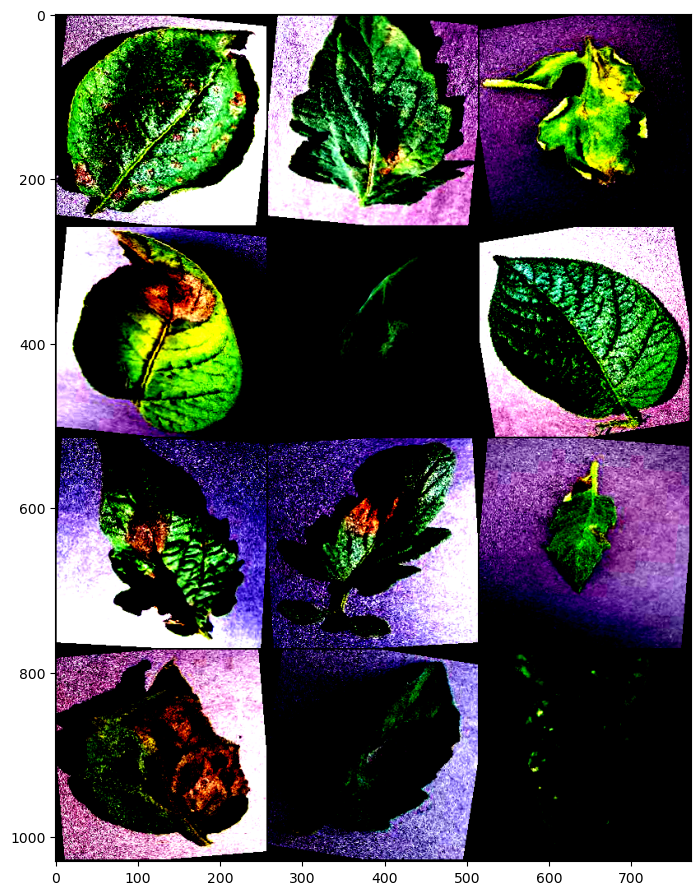

In [108]:
show_transformed_images(training_dataset)

In [109]:
validate_dataset='../Datasets/dataset_2_classes/validate/'
validate_loader,validating_dataset=train_transform(validate_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1])


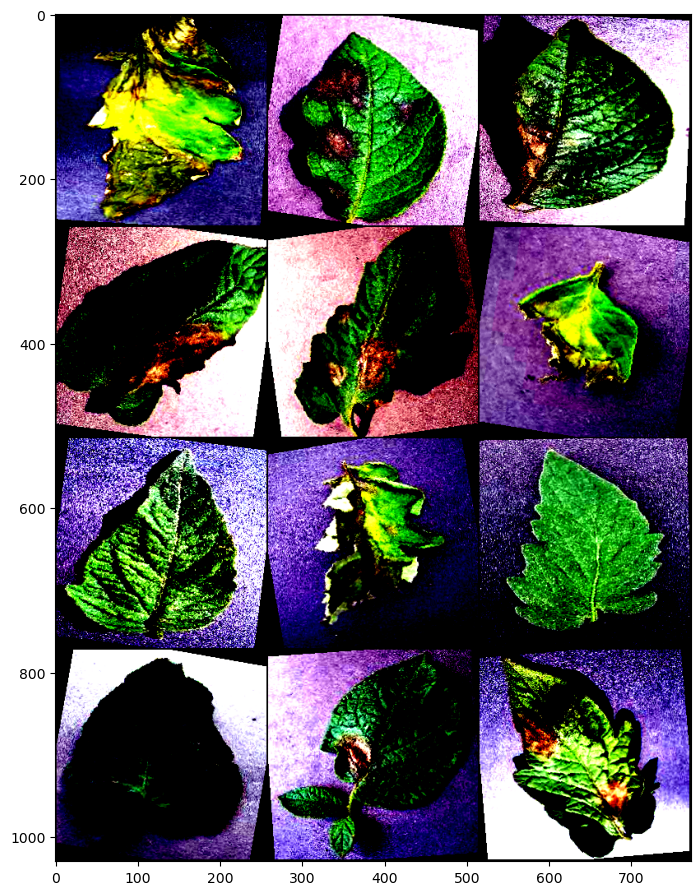

In [110]:
show_transformed_images(validating_dataset)

In [111]:
test_dataset='../Datasets/dataset_2_classes/test/'
test_loader,testing_dataset=train_transform(test_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1])


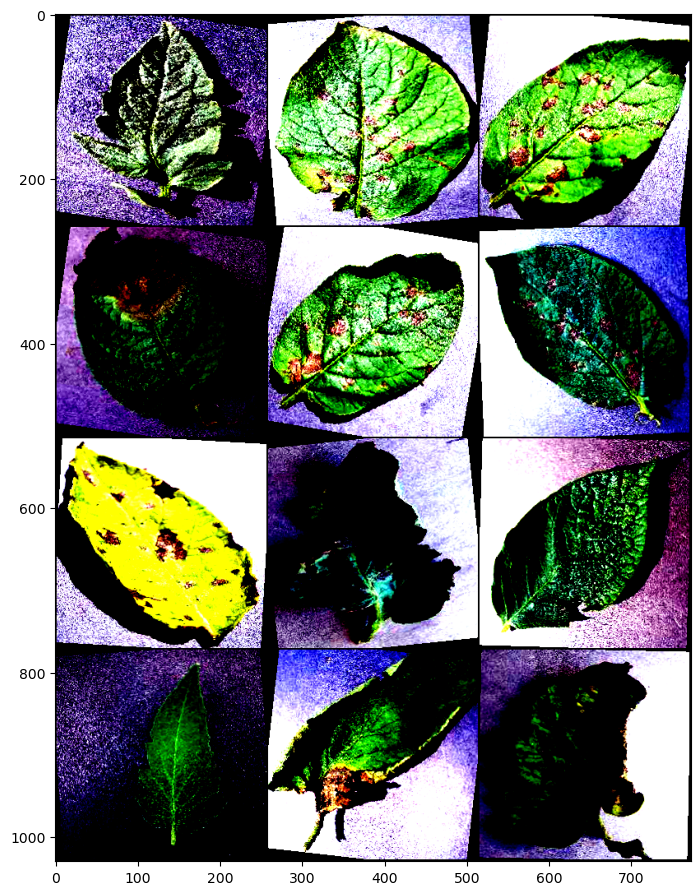

In [112]:
show_transformed_images(testing_dataset)

In [113]:
def set_device():
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    return device

In [114]:
resnet34_Model = models.resnet34(pretrained=False, num_classes=2)

/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [115]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [116]:
count_parameters(resnet34_Model)

21285698

In [117]:
device=set_device()
resnet34_Model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [118]:
print("Device: {}".format(device))

Device: mps


In [119]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet34_Model.parameters(), lr=0.0002,momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)
n_epochs = 5
epoch_count = 0
Accuracies = [] 
valAccuracies = []
valLoss = []
trainLoss = []
total_steps = len(train_loader)
t1 = time.time()
validation_accuracy = 0

In [120]:
for epoch in range(n_epochs):
    print("Epoch: %d "%(epoch+1))
    resnet34_Model.train()
    running_loss=0.0
    running_correct=0.0
    val_loss=0.0
    total=0
    for i,data in enumerate(train_loader):
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)
        total+=labels.size(0)
        optimizer.zero_grad()
        outputs=resnet34_Model(images)
        print(outputs.data)
        _,predicted=torch.max(outputs.data,1)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        running_correct+=(labels==predicted).sum().item()
        traning_accuracy=(running_correct/total)*100
    
    validation_accuracy=0
    resnet34_Model.eval()
    with torch.no_grad():
        val_correct=0
        val_total=0
        val_loss=0
        for data in validate_loader:
            images,val_labels=data[0].to(device), data[1].to(device)
            images = images.to(device)
            val_labels = val_labels.to(device)
            outputs=resnet34_Model(images)
            loss_val=criterion(outputs,val_labels)
            val_loss+= loss_val.item()
            _,predicted=torch.max(outputs.data,1)
            val_correct+=(predicted == val_labels).sum().item()
            val_total+=val_labels.size(0)
        validation_accuracy = (val_correct / val_total) *100
    
    scheduler.step()
    epoch_loss=running_loss/len(train_loader)
    val_loss=val_loss/len(validate_loader)
    epoch_accuracy=100.00* running_correct/total
    Accuracies.append(epoch_accuracy)
    valAccuracies.append(validation_accuracy)
    trainLoss.append(epoch_loss)
    valLoss.append(val_loss)
    
    print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f"%(epoch_loss,epoch_accuracy,val_loss))
    
        

Epoch: 1 
tensor([[-0.9857,  0.2538],
        [-0.7875,  0.4719],
        [-0.8457,  0.3402],
        [-1.2515,  0.4567],
        [-0.9633,  0.4862],
        [-0.9940,  0.5028],
        [-0.8915,  0.4694],
        [-1.0049,  0.6257],
        [-1.1305,  0.5016],
        [-0.9042,  0.3742],
        [-1.0292,  0.5283],
        [-0.8419,  0.3670],
        [-0.9949,  0.3805],
        [-0.8302,  0.2944],
        [-0.8515,  0.4071],
        [-0.8986,  0.4168],
        [-0.7917,  0.3971],
        [-0.7631,  0.4367],
        [-0.8438,  0.3921],
        [-0.9689,  0.3851],
        [-0.9483,  0.3641],
        [-1.1803,  0.5056],
        [-0.9559,  0.5427],
        [-0.9765,  0.3189],
        [-0.9577,  0.3984],
        [-1.0959,  0.2585],
        [-0.9490,  0.3302],
        [-0.9821,  0.3865],
        [-0.8079,  0.2904],
        [-0.7113,  0.3918],
        [-1.0785,  0.5256],
        [-0.8639,  0.4557]], device='mps:0')
tensor([[-1.0965,  0.5988],
        [-0.7425,  0.4566],
        [-1.0791,  0.

tensor([[-1.0417,  0.3741],
        [-1.1139,  0.4016],
        [-0.9329,  0.4128],
        [-1.2419,  0.4156],
        [-0.8840,  0.4661],
        [-0.9340,  0.2301],
        [-0.8714,  0.4890],
        [-0.8873,  0.5008],
        [-1.0127,  0.4218],
        [-1.0850,  0.6189],
        [-0.8763,  0.4325],
        [-1.0182,  0.4271],
        [-0.8980,  0.3722],
        [-0.9349,  0.4693],
        [-0.9274,  0.5340],
        [-0.8167,  0.3902],
        [-0.8272,  0.4004],
        [-1.0360,  0.4479],
        [-0.8968,  0.3137],
        [-0.9690,  0.4551],
        [-0.9893,  0.3647],
        [-1.0201,  0.6138],
        [-0.8316,  0.5745],
        [-0.8849,  0.4623],
        [-1.1200,  0.5175],
        [-1.1464,  0.6597],
        [-0.9437,  0.2691],
        [-0.8056,  0.4873],
        [-0.9236,  0.4081],
        [-0.9385,  0.4320],
        [-1.0020,  0.5635],
        [-1.0363,  0.4046]], device='mps:0')
tensor([[-0.9314,  0.4369],
        [-1.0339,  0.4194],
        [-0.9469,  0.3504],
   

tensor([[-1.0334,  0.3910],
        [-0.9867,  0.5462],
        [-1.0039,  0.3083],
        [-0.8737,  0.4398],
        [-1.0366,  0.5049],
        [-0.8683,  0.2986],
        [-0.9291,  0.4230],
        [-1.0084,  0.3568],
        [-1.1848,  0.8145],
        [-0.9560,  0.4152],
        [-0.7233,  0.4477],
        [-0.9979,  0.5106],
        [-1.0504,  0.3552],
        [-0.9024,  0.4439],
        [-0.8025,  0.4764],
        [-0.9470,  0.4746],
        [-0.9138,  0.5587],
        [-0.9044,  0.4710],
        [-0.9838,  0.3301],
        [-0.9753,  0.4468],
        [-1.0691,  0.4566],
        [-0.8417,  0.4759],
        [-0.8015,  0.3581],
        [-1.1061,  0.4198],
        [-0.9431,  0.4910],
        [-0.9792,  0.5185],
        [-1.0210,  0.5107],
        [-1.0043,  0.3681],
        [-0.9721,  0.4632],
        [-0.8700,  0.3956],
        [-1.0088,  0.3776],
        [-0.9456,  0.4751]], device='mps:0')
tensor([[-0.9921,  0.4067],
        [-0.9550,  0.4894],
        [-1.0447,  0.4866],
   

tensor([[-0.9969,  0.4202],
        [-1.0692,  0.5305],
        [-0.9847,  0.4582],
        [-0.9913,  0.6224],
        [-0.7900,  0.4820],
        [-0.9875,  0.4469],
        [-0.7882,  0.4302],
        [-0.9516,  0.5316],
        [-0.9580,  0.4004],
        [-0.9917,  0.3865],
        [-0.9606,  0.4918],
        [-1.0108,  0.4625],
        [-0.9487,  0.4600],
        [-0.9517,  0.3679],
        [-1.1015,  0.5306],
        [-0.8857,  0.4489],
        [-1.0900,  0.4035],
        [-1.0190,  0.5155],
        [-1.1165,  0.4180],
        [-0.9863,  0.4192],
        [-1.0924,  0.5566],
        [-1.0801,  0.4246],
        [-0.9929,  0.5494],
        [-0.9140,  0.4644],
        [-0.9326,  0.6202],
        [-1.0741,  0.4772],
        [-0.9057,  0.5045],
        [-0.9451,  0.2585],
        [-1.0494,  0.3439],
        [-0.7972,  0.3722],
        [-0.9519,  0.3776],
        [-0.9475,  0.4141]], device='mps:0')
tensor([[-0.9462,  0.4553],
        [-1.0912,  0.2810],
        [-0.9034,  0.5708],
   

tensor([[-1.0873,  0.4429],
        [-1.0821,  0.3505],
        [-1.0729,  0.4411],
        [-1.0406,  0.6385],
        [-0.9079,  0.5317],
        [-0.9903,  0.4621],
        [-0.8223,  0.5493],
        [-1.0102,  0.5203],
        [-1.0936,  0.5569],
        [-1.0909,  0.5136],
        [-0.8680,  0.5738],
        [-1.0512,  0.5224],
        [-1.0602,  0.4635],
        [-0.8866,  0.5744],
        [-1.0141,  0.4497],
        [-0.9108,  0.5072],
        [-1.0307,  0.3972],
        [-1.0561,  0.4179],
        [-1.0266,  0.4472],
        [-1.1563,  0.5621],
        [-1.0200,  0.5725],
        [-0.9105,  0.6358],
        [-1.0877,  0.6079],
        [-1.0024,  0.5381],
        [-0.9671,  0.5642],
        [-1.2521,  0.6891],
        [-1.0017,  0.5998],
        [-0.9988,  0.2324],
        [-1.0169,  0.4143],
        [-1.0362,  0.5646],
        [-1.1305,  0.3087],
        [-1.1817,  0.4125]], device='mps:0')
tensor([[-0.9483,  0.4562],
        [-0.9606,  0.4984],
        [-1.0565,  0.5496],
   

tensor([[-1.0239,  0.4807],
        [-1.0257,  0.6400],
        [-0.8733,  0.2902],
        [-0.8888,  0.4602],
        [-0.8777,  0.4080],
        [-0.6599,  0.2911],
        [-0.9378,  0.2716],
        [-0.9434,  0.5275],
        [-1.0346,  0.3614],
        [-0.9410,  0.6726],
        [-0.8913,  0.5295],
        [-0.9348,  0.3080],
        [-0.9748,  0.4012],
        [-0.9177,  0.4365],
        [-0.6442,  0.3840],
        [-0.9732,  0.1227],
        [-0.8045,  0.3703],
        [-0.9697,  0.5646],
        [-0.9319,  0.3713],
        [-0.9596,  0.3698],
        [-0.7292,  0.2317],
        [-0.9553,  0.4877],
        [-1.0047,  0.1167],
        [-0.9601,  0.5259],
        [-0.9577,  0.3324],
        [-0.8706,  0.3564],
        [-0.9319,  0.2645],
        [-0.9126,  0.4113],
        [-1.0126,  0.5620],
        [-0.9213,  0.5139],
        [-0.9505,  0.4355],
        [-0.9352,  0.4005]], device='mps:0')
tensor([[-0.8364,  0.5414],
        [-0.9690,  0.4543],
        [-1.0665,  0.4416],
   

tensor([[-1.2274,  0.5135],
        [-0.8360,  0.1427],
        [-0.9142,  0.2647],
        [-0.9782,  0.5911],
        [-0.9702,  0.4362],
        [-0.9781,  0.6113],
        [-1.0662,  0.4710],
        [-1.1221,  0.7390],
        [-0.9893,  0.3227],
        [-0.9915,  0.5054],
        [-0.9838,  0.3715],
        [-0.9261,  0.4349],
        [-0.9085,  0.4953],
        [-0.8723,  0.3668],
        [-1.1311,  0.6403],
        [-1.0860,  0.5358],
        [-0.8383,  0.3544],
        [-0.8629,  0.2645],
        [-0.9244,  0.4581],
        [-1.0744,  0.5233],
        [-0.9639,  0.8381],
        [-1.1424,  0.5918],
        [-1.1151,  0.5643],
        [-0.9111,  0.4260],
        [-1.0637,  0.6830],
        [-1.0243,  0.6945],
        [-1.1222,  0.7101],
        [-1.2261,  0.4781],
        [-0.9756,  0.5123],
        [-1.1603,  0.5937],
        [-1.0531,  0.5024],
        [-0.9633,  0.4432]], device='mps:0')
tensor([[-1.1753,  0.7000],
        [-0.6630,  0.5645],
        [-0.9672,  0.4722],
   

tensor([[-1.0257,  0.5190],
        [-1.0369,  0.5447],
        [-0.9741,  0.3137],
        [-0.9122,  0.3967],
        [-1.0733,  0.5795],
        [-1.0306,  0.4877],
        [-1.0569,  0.4391],
        [-1.0200,  0.6130],
        [-0.9959,  0.3892],
        [-1.1725,  0.6137],
        [-1.0248,  0.5102],
        [-1.2149,  0.6497],
        [-0.9252,  0.4352],
        [-0.9736,  0.6692],
        [-1.0759,  0.3151],
        [-1.0245,  0.6678],
        [-1.1719,  0.4764],
        [-1.2185,  0.5996],
        [-0.9865,  0.4185],
        [-1.0782,  0.6754],
        [-1.1798,  0.6387],
        [-0.9728,  0.3198],
        [-1.0840,  0.7197],
        [-1.2632,  0.6476],
        [-0.9646,  0.4498],
        [-1.1833,  0.7222],
        [-1.0523,  0.4497],
        [-1.1377,  0.4876],
        [-1.1157,  0.6805],
        [-0.9798,  0.3698],
        [-0.8579,  0.5127],
        [-1.0369,  0.5191]], device='mps:0')
Training Data: Epoch Loss: 0.462, Epoch Accuracy: 81.152, Validation Loss: 0.570
Epoch:

tensor([[-0.9622,  0.5660],
        [-1.2630,  0.7185],
        [-1.1721,  0.7297],
        [-1.2151,  0.6807],
        [-1.1902,  0.6887],
        [-1.1144,  0.4727],
        [-1.1362,  0.6983],
        [-1.0426,  0.6850],
        [-1.2386,  0.5730],
        [-1.0209,  0.5171],
        [-1.1979,  0.5746],
        [-1.0216,  0.4658],
        [-1.2027,  0.6590],
        [-1.0266,  0.6078],
        [-1.1287,  0.5663],
        [-0.9348,  0.3165],
        [-0.9614,  0.5328],
        [-1.0590,  0.4812],
        [-1.0410,  0.5798],
        [-1.2897,  0.5958],
        [-1.0785,  0.6847],
        [-1.0263,  0.3996],
        [-1.1088,  0.3818],
        [-0.8769,  0.3754],
        [-0.9589,  0.4955],
        [-1.1409,  0.5885],
        [-1.0941,  0.6641],
        [-0.9707,  0.4888],
        [-0.8715,  0.5928],
        [-1.0766,  0.4962],
        [-1.2168,  0.5382],
        [-1.1081,  0.3539]], device='mps:0')
tensor([[-1.0946,  0.6542],
        [-1.1378,  0.6628],
        [-1.0879,  0.6498],
   

tensor([[-0.9249,  0.3356],
        [-1.0624,  0.5276],
        [-1.1782,  0.4632],
        [-1.1234,  0.7433],
        [-1.1394,  0.6301],
        [-0.9544,  0.4582],
        [-0.9019,  0.3235],
        [-1.2225,  0.7547],
        [-0.9901,  0.5153],
        [-0.8869,  0.8279],
        [-0.9091,  0.2999],
        [-1.0232,  0.5609],
        [-0.7605,  0.3286],
        [-0.9788,  0.3914],
        [-1.1502,  0.5198],
        [-1.1192,  0.5194],
        [-0.9248,  0.4578],
        [-0.8126,  0.2867],
        [-0.9288,  0.3392],
        [-0.8828,  0.2436],
        [-0.8373,  0.2258],
        [-1.1021,  0.6881],
        [-1.0111,  0.4617],
        [-1.0564,  0.3308],
        [-0.8738,  0.4655],
        [-1.0143,  0.6617],
        [-1.1855,  0.4875],
        [-1.0519,  0.6354],
        [-0.9639,  0.2096],
        [-0.9574,  0.3988],
        [-1.0400,  0.6097],
        [-1.0171,  0.5319]], device='mps:0')
tensor([[-1.2516,  0.7532],
        [-1.0555,  0.5841],
        [-0.9275,  0.6633],
   

tensor([[-0.7709,  0.2557],
        [-1.0106,  0.2648],
        [-0.9173,  0.4951],
        [-0.8540,  0.5105],
        [-0.8636,  0.5102],
        [-1.1085,  0.3830],
        [-0.8076,  0.3202],
        [-0.8980,  0.1897],
        [-1.1293,  0.5406],
        [-0.9413,  0.6729],
        [-1.0482,  0.6409],
        [-1.0245,  0.8611],
        [-0.9026,  0.1925],
        [-0.9911,  0.5302],
        [-0.9939,  0.3419],
        [-0.9272,  0.2515],
        [-1.0809,  0.5815],
        [-1.1450,  0.7647],
        [-0.8593,  0.4908],
        [-1.0199,  0.5197],
        [-1.0403,  0.4806],
        [-0.9645,  0.4627],
        [-1.1051,  0.5014],
        [-0.8122,  0.3949],
        [-1.1926,  0.8418],
        [-1.0427,  0.2966],
        [-0.9149,  0.4699],
        [-0.8378,  0.1737],
        [-0.8042,  0.2142],
        [-1.1032,  0.8114],
        [-1.0691,  0.4541],
        [-0.8282,  0.1922]], device='mps:0')
tensor([[-0.9301,  0.2529],
        [-0.6621,  0.1917],
        [-1.0227,  0.5691],
   

tensor([[-1.1206,  0.5924],
        [-1.0326,  0.6177],
        [-1.0156,  0.4963],
        [-0.7615,  0.5260],
        [-0.9883,  0.3018],
        [-0.8858,  0.5982],
        [-0.9042,  0.3412],
        [-0.7784,  0.2086],
        [-0.9774,  0.3340],
        [-0.7732,  0.1542],
        [-0.7868,  0.2838],
        [-1.0026,  0.5946],
        [-0.9521,  0.5626],
        [-0.8869,  0.3998],
        [-0.8815,  0.3121],
        [-0.5869,  0.3361],
        [-1.0930,  0.4928],
        [-1.0794,  0.4488],
        [-0.9714,  0.5618],
        [-1.0196,  0.3611],
        [-0.7072,  0.1901],
        [-0.6338,  0.0850],
        [-0.9364,  0.4252],
        [-0.9069,  0.3518],
        [-1.3221,  0.6687],
        [-0.8046,  0.3197],
        [-1.0828,  0.6453],
        [-0.7695,  0.2487],
        [-1.2081,  0.8682],
        [-0.8682,  0.4714],
        [-1.1240,  0.6107],
        [-1.0254,  0.3098]], device='mps:0')
tensor([[-1.1519,  0.4678],
        [-1.1782,  0.8151],
        [-0.8991,  0.3966],
   

tensor([[-0.8296,  0.3406],
        [-1.1495,  0.7064],
        [-0.8563,  0.2184],
        [-1.2264,  0.8322],
        [-1.0653,  0.4896],
        [-0.8980,  0.3129],
        [-0.9009,  0.4760],
        [-0.9213,  0.3122],
        [-1.1045,  0.4894],
        [-1.0691,  0.6838],
        [-0.9423,  0.5442],
        [-1.0107,  0.5385],
        [-1.1075,  0.8525],
        [-1.0462,  0.6820],
        [-1.0489,  0.4081],
        [-1.0871,  0.5596],
        [-0.8857,  0.4295],
        [-1.1696,  0.5141],
        [-1.1562,  0.7145],
        [-1.0818,  0.3855],
        [-0.9669,  0.3801],
        [-1.1994,  0.7215],
        [-1.3049,  0.7453],
        [-1.3786,  0.6975],
        [-1.1600,  0.6085],
        [-1.1084,  0.7812],
        [-0.8722,  0.2125],
        [-1.1285,  0.5958],
        [-1.0307,  0.6660],
        [-1.1356,  0.5671],
        [-1.1518,  0.5437],
        [-1.2642,  0.6688]], device='mps:0')
tensor([[-1.0068,  0.3134],
        [-1.0319,  0.6051],
        [-1.4069,  0.9254],
   

tensor([[-0.8793,  0.5158],
        [-0.8116,  0.3301],
        [-1.3262,  0.8408],
        [-1.3570,  0.9278],
        [-1.2869,  0.8236],
        [-1.1469,  0.6940],
        [-1.2030,  0.3701],
        [-1.3225,  0.9824],
        [-1.0068,  0.3249],
        [-1.0230,  0.4747],
        [-1.0232,  0.1935],
        [-1.0921,  0.6099],
        [-1.3473,  0.8935],
        [-1.3687,  1.0201],
        [-1.0172,  0.4872],
        [-1.0277,  0.4312],
        [-1.0929,  0.7364],
        [-1.3566,  0.7901],
        [-1.2508,  0.7654],
        [-0.8210,  0.4666],
        [-2.0765,  1.4017],
        [-1.0996,  0.4874],
        [-1.3238,  0.7403],
        [-0.8810,  0.2419],
        [-0.9236,  0.3380],
        [-1.1300,  0.5476],
        [-1.0902,  0.6193],
        [-1.1338,  0.6798],
        [-1.0739,  0.3288],
        [-0.9127,  0.5181],
        [-1.4649,  1.3442],
        [-1.2588,  0.8271]], device='mps:0')
tensor([[-0.9522,  0.3618],
        [-1.5481,  0.7770],
        [-1.3231,  0.8641],
   

tensor([[-1.3741,  0.9796],
        [-0.8725,  0.3724],
        [-0.7700,  0.1591],
        [-1.0873,  0.6476],
        [-0.8447,  0.4568],
        [-0.7262,  0.3699],
        [-1.0447,  0.2600],
        [-0.8966,  0.3104],
        [-0.5455, -0.1888],
        [-0.7537,  0.0701],
        [-1.1014,  0.6458],
        [-0.6110,  0.1334],
        [-1.2305,  0.7217],
        [-0.5985,  0.0862],
        [-0.8314, -0.2134],
        [-0.7567,  0.2821],
        [-0.9596,  0.5656],
        [-1.2091,  0.7396],
        [-1.0477,  0.6021],
        [-0.9526,  0.5545],
        [-1.1925,  0.7534],
        [-1.0563,  0.8250],
        [-0.8008,  0.3212],
        [-0.7138,  0.1552],
        [-0.8032,  0.1688],
        [-0.7661,  0.4815],
        [-0.8066,  0.3098],
        [-0.8314,  0.4066],
        [-0.5742, -0.0759],
        [-0.4529, -0.0352],
        [-0.8247,  0.5297],
        [-0.8258,  0.2695]], device='mps:0')
tensor([[-0.8785,  0.5357],
        [-0.7759,  0.2950],
        [-0.7344,  0.2966],
   

tensor([[-1.0487,  0.7940],
        [-1.2774,  0.8229],
        [-0.6304, -0.0427],
        [-0.9476,  0.1965],
        [-0.4002, -0.1062],
        [-1.0172,  0.5277],
        [-0.9955,  0.4350],
        [-0.9529,  0.4468],
        [-0.5638, -0.0625],
        [-0.4529,  0.0039],
        [-0.7944,  0.0447],
        [-0.6340, -0.0504],
        [-1.0883,  0.6694],
        [-1.4000,  0.9714],
        [-1.5663,  0.8885],
        [-1.2868,  1.1108],
        [-1.2029,  0.6351],
        [-1.2640,  0.9614],
        [-0.8492,  0.0614],
        [-0.9049,  0.2874],
        [-1.0252,  0.6029],
        [-1.2150,  0.8209],
        [-1.3221,  0.8673],
        [-0.9446,  0.4001],
        [-1.1818,  0.7616],
        [-0.9367,  0.4300],
        [-1.2070,  0.7947],
        [-0.6957, -0.0112],
        [-1.0772,  0.3879],
        [-1.0726,  0.5694],
        [-0.6934,  0.1256],
        [-0.8633,  0.5290]], device='mps:0')
tensor([[-0.7914,  0.3462],
        [-0.8510,  0.3021],
        [-0.9306,  0.3638],
   

tensor([[-0.6975,  0.1134],
        [-1.0662,  0.6784],
        [-1.4883,  0.8982],
        [-1.0652,  0.5477],
        [-1.2188,  0.6360],
        [-1.4420,  0.9301],
        [-1.3653,  0.7814],
        [-0.5779,  0.0422],
        [-1.3938,  0.7776],
        [-0.9285,  0.3128],
        [-1.0984,  0.7881],
        [-1.1165,  0.6344],
        [-1.3532,  1.0689],
        [-1.4408,  1.1601],
        [-1.3407,  1.0580],
        [-1.3944,  0.7541],
        [-1.1888,  0.5608],
        [-1.0897,  0.4836],
        [-1.2578,  0.6768],
        [-0.7013,  0.0631],
        [-1.5601,  0.8510],
        [-1.2549,  0.7375],
        [-0.7374,  0.0542],
        [-1.3627,  0.8982],
        [-1.4732,  1.0498],
        [-1.0923,  0.8067],
        [-0.6748,  0.0614],
        [-1.1579,  0.5577],
        [-1.1537,  0.6169],
        [-1.4733,  0.9768],
        [-0.9860,  0.3753],
        [-0.9630,  0.4147]], device='mps:0')
tensor([[-1.2097,  0.6860],
        [-1.5946,  1.0437],
        [-1.7605,  1.0328],
   

tensor([[-1.6947,  1.4426],
        [-0.8416,  0.3192],
        [-1.4063,  1.0508],
        [-0.8623,  0.3582],
        [-0.2505, -0.5778],
        [-1.2993,  0.9225],
        [-0.9443,  0.1879],
        [-0.6894,  0.1796],
        [-0.9925,  0.4077],
        [-0.8423,  0.2103],
        [-1.6839,  1.0039],
        [-1.2557,  0.9773],
        [-1.1111,  0.6342],
        [-0.5038,  0.0515],
        [-0.6076, -0.0109],
        [-1.2092,  1.2455],
        [-1.3709,  0.9596],
        [-0.4000, -0.2321],
        [-1.2984,  0.7040],
        [-0.7203,  0.1283],
        [-0.2933, -0.1819],
        [-0.3625, -0.3730],
        [-1.0885,  0.7974],
        [-1.4521,  0.9905],
        [-1.0354,  0.4250],
        [-0.7833,  0.1946],
        [-0.5377, -0.2005],
        [-1.2596,  0.7166],
        [-0.5825, -0.0745],
        [-0.8283,  0.2397],
        [-1.3246,  0.8635],
        [-0.7523,  0.2060]], device='mps:0')
tensor([[-0.7521,  0.3193],
        [-1.1225,  0.8210],
        [-0.3448, -0.5371],
   

In [121]:
print("---Training finished in {} seconds---".format(time.time()-t1))
epoch_count+=n_epochs
torch.save(resnet34_Model.state_dict(), "2-Class-Resnet34-"+str(epoch_count)+"-epoch.pt")

---Training finished in 106.31766891479492 seconds---


In [122]:

from torchmetrics import F1Score,ConfusionMatrix

In [123]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [124]:
test_acc = evaluate_model(resnet34_Model,test_loader)

Testing Data: Epoch Accuracy: 90.039


In [125]:
dict = {'Training': Accuracies, 'Validation': valAccuracies} 
dictLoss = {'Training': trainLoss,'Validation': valLoss}
df = pd.DataFrame(dict)
df2 = pd.DataFrame(dictLoss)
df.to_csv("Accuracies_Resnet34_2classes"+str(epoch_count)+".csv")
df2.to_csv("Loss_Resnet34_2classes"+str(epoch_count)+".csv")

In [126]:
print(val_loss/len(validate_loader))

0.018303041791969957


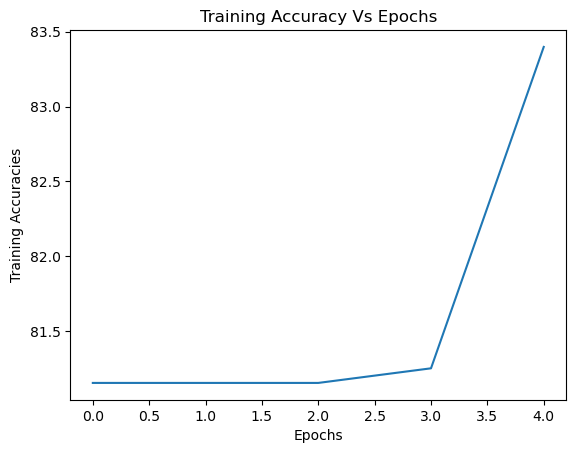

In [127]:
plt.plot(range(n_epochs),Accuracies)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracies")
plt.title("Training Accuracy Vs Epochs")
plt.show()

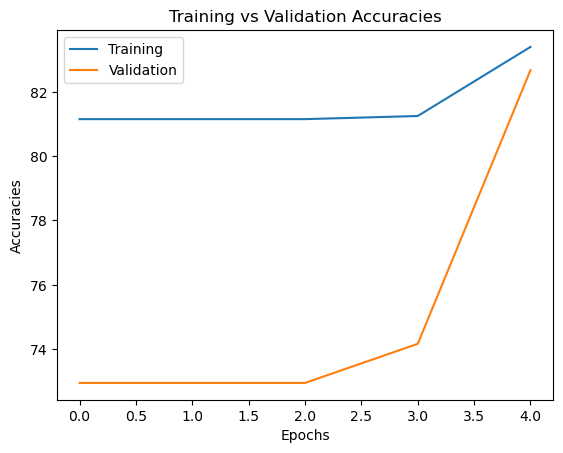

In [128]:
plt.plot(range(n_epochs),Accuracies, label="Training")
plt.plot(range(n_epochs),valAccuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training vs Validation Accuracies")
plt.legend()
plt.show()

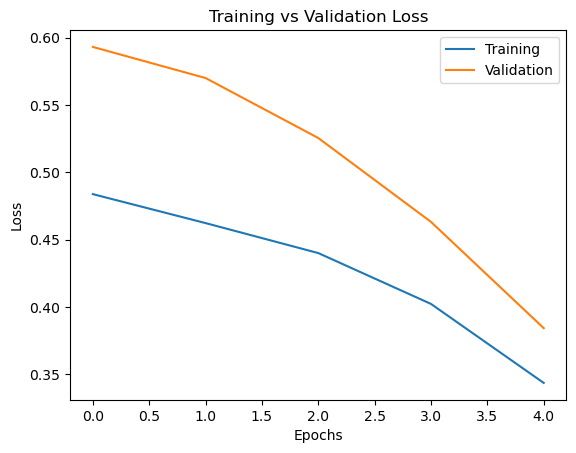

In [129]:
plt.plot(range(n_epochs),trainLoss, label="Training")
plt.plot(range(n_epochs),valLoss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [130]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay

In [131]:
y_pred = []
y_true = []

for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = resnet34_Model(inputs) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

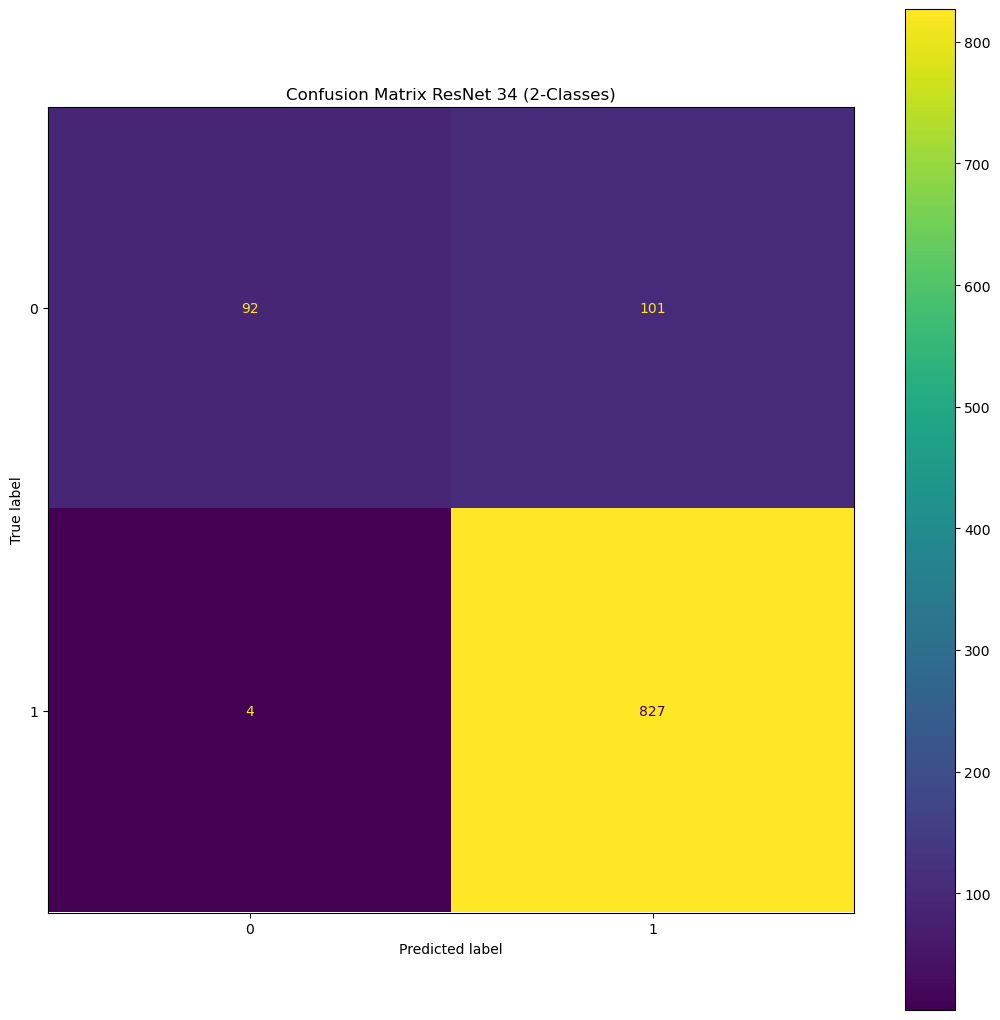

In [132]:
classes = (0,1)
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
fig,ax = plt.subplots()
fig.set_size_inches(13,13)
plt.title("Confusion Matrix ResNet 34 (2-Classes)")
disp.plot(ax=ax)
plt.show()

In [133]:
print("Precision Macro:{:.2f}".format(precision_score(y_true, y_pred, average='macro')))
print("Precision Micro:{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall Macro:{:.2f}".format(recall_score(y_true,y_pred,average='macro')))
print("Recall Micro:{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score Macro:{:.2f}".format(f1_score(y_true,y_pred,average='macro')))
print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

Precision Macro:0.92
Precision Micro:0.90
Recall Macro:0.74
Recall Micro:0.90
F1-Score Macro:0.79
F1-Score Micro:0.90


Test Accuracy of the model on the 1024 test images: 89.6484375 %


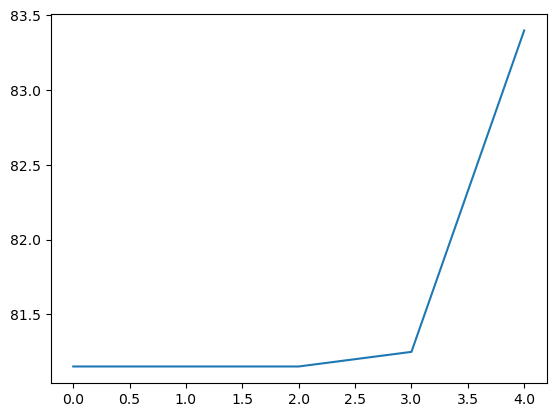

In [134]:
resnet34_Model.eval() 
perds = []
target = []
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet34_Model(images)
        _, predicted = torch.max(outputs.data, 1)
        perds.extend(predicted)
        target.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))
    
plt.plot(Accuracies)